Predict age, gender and ethnicity of people using any Pre-trained and UTK Face datasets
https://www.kaggle.com/datasets/jangedoo/utkface-new

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.jason ~/.kaggle

cp: cannot stat 'kaggle.jason': No such file or directory


In [2]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 95% 314M/331M [00:03<00:00, 110MB/s] 
100% 331M/331M [00:03<00:00, 102MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/utkface-new.zip")
zip_ref.extractall("content")
zip_ref.close()

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from pathlib import Path

In [6]:
path = Path("/content/content/UTKFace")
filenames = list(map(lambda x: x.name, path.glob("*.jpg")))

In [7]:
print(len(filenames))

23708


In [8]:
print(filenames[:3])

['3_1_0_20170109192805549.jpg.chip.jpg', '45_0_0_20170117191748012.jpg.chip.jpg', '38_1_1_20170117142941700.jpg.chip.jpg']


In [9]:
np.random.seed(10)
np.random.shuffle(filenames)
age_labels, gender_labels, race_labels, image_path = [], [], [], []

for filename in filenames:
  image_path.append(filename)
  temp = filename.split("_")
  age_labels.append(temp[0])
  gender_labels.append(temp[1])
  race_labels.append(temp[2])

In [10]:
df = pd.DataFrame()
df["image"], df["age"], df["gender"], df["race"] = image_path, age_labels, gender_labels, race_labels

In [11]:
df.head()

,image,age,gender,race
0,21_1_1_20170112193015117.jpg.chip.jpg,21,1,1
1,35_1_0_20170104171655778.jpg.chip.jpg,35,1,0
2,28_1_2_20170116165530274.jpg.chip.jpg,28,1,2
3,35_1_0_20170116201540728.jpg.chip.jpg,35,1,0
4,23_0_1_20170113150913751.jpg.chip.jpg,23,0,1


In [12]:
df["race"].value_counts()

,count
race,
0,10078
1,4526
3,3975
2,3434
4,1692
20170116174525125.jpg.chip.jpg,1
20170109142408075.jpg.chip.jpg,1
20170109150557335.jpg.chip.jpg,1


In [13]:
# Remove outliers
df = df[df["race"].isin(["0", "1", "2", "3", "4"])]
df["race"].value_counts()

,count
race,
0,10078
1,4526
3,3975
2,3434
4,1692


In [14]:
gender_dict = {0:"Male", 1:"Female"}
race_dict = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others"}

In [15]:
df.head()

,image,age,gender,race
0,21_1_1_20170112193015117.jpg.chip.jpg,21,1,1
1,35_1_0_20170104171655778.jpg.chip.jpg,35,1,0
2,28_1_2_20170116165530274.jpg.chip.jpg,28,1,2
3,35_1_0_20170116201540728.jpg.chip.jpg,35,1,0
4,23_0_1_20170113150913751.jpg.chip.jpg,23,0,1


In [16]:
df["age"] = df["age"].astype("int32")
df["gender"] = df["gender"].astype("int32")
df["race"] = df["race"].astype("int32")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23705 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   23705 non-null  object
 1   age     23705 non-null  int32 
 2   gender  23705 non-null  int32 
 3   race    23705 non-null  int32 
dtypes: int32(3), object(1)
memory usage: 648.2+ KB


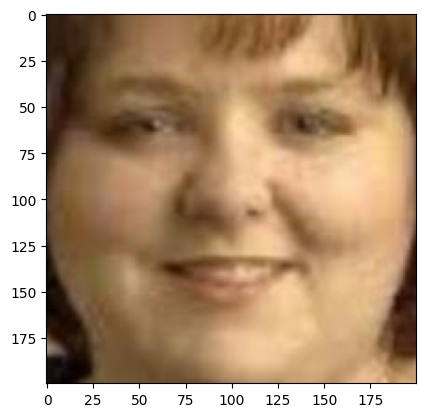

In [18]:
img = Image.open("/content/content/UTKFace/"+df["image"][1])
plt.imshow(img)

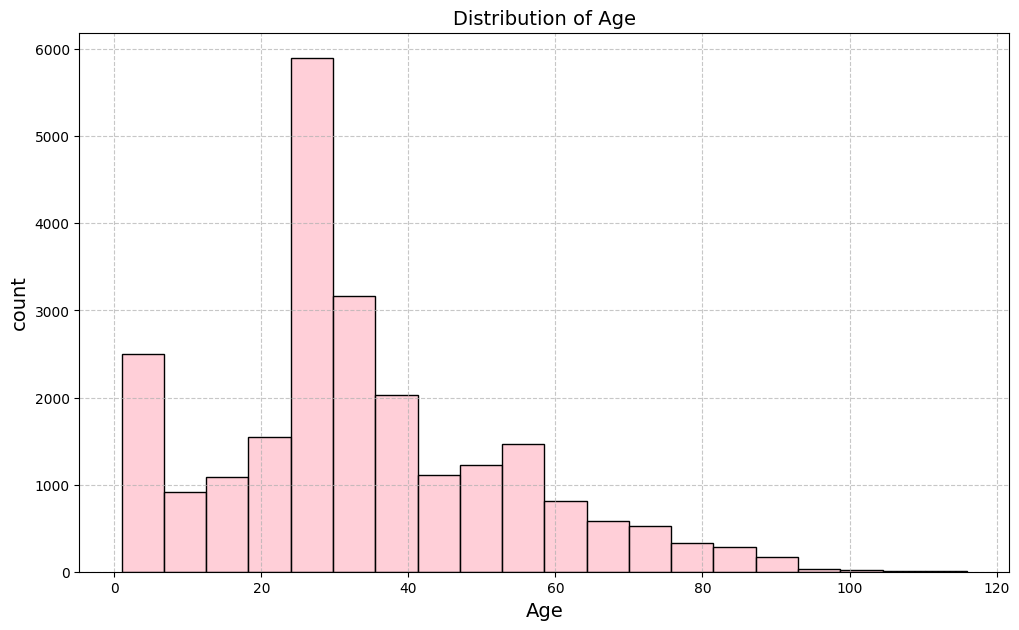

In [19]:
# Set the size of the graph.
plt.figure(figsize=(12,7))

# Create Histogram graph using Seaborn
sns.histplot(df["age"], bins=20, kde=False, color="pink", edgecolor="black")

# Adjust the format of the graph
plt.title("Distribution of Age", fontsize=14)
plt.xlabel("Age", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)

# Show graph
plt.show()

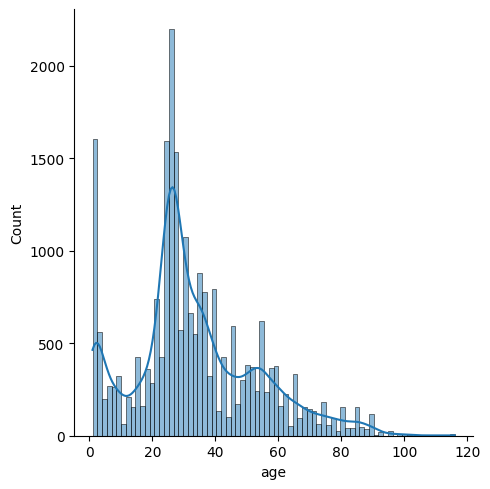

In [20]:
sns.displot(df["age"], kde=True)

In [21]:
# sns.countplot(df["gender"])

In [22]:
# sns.barplot(df["race"])

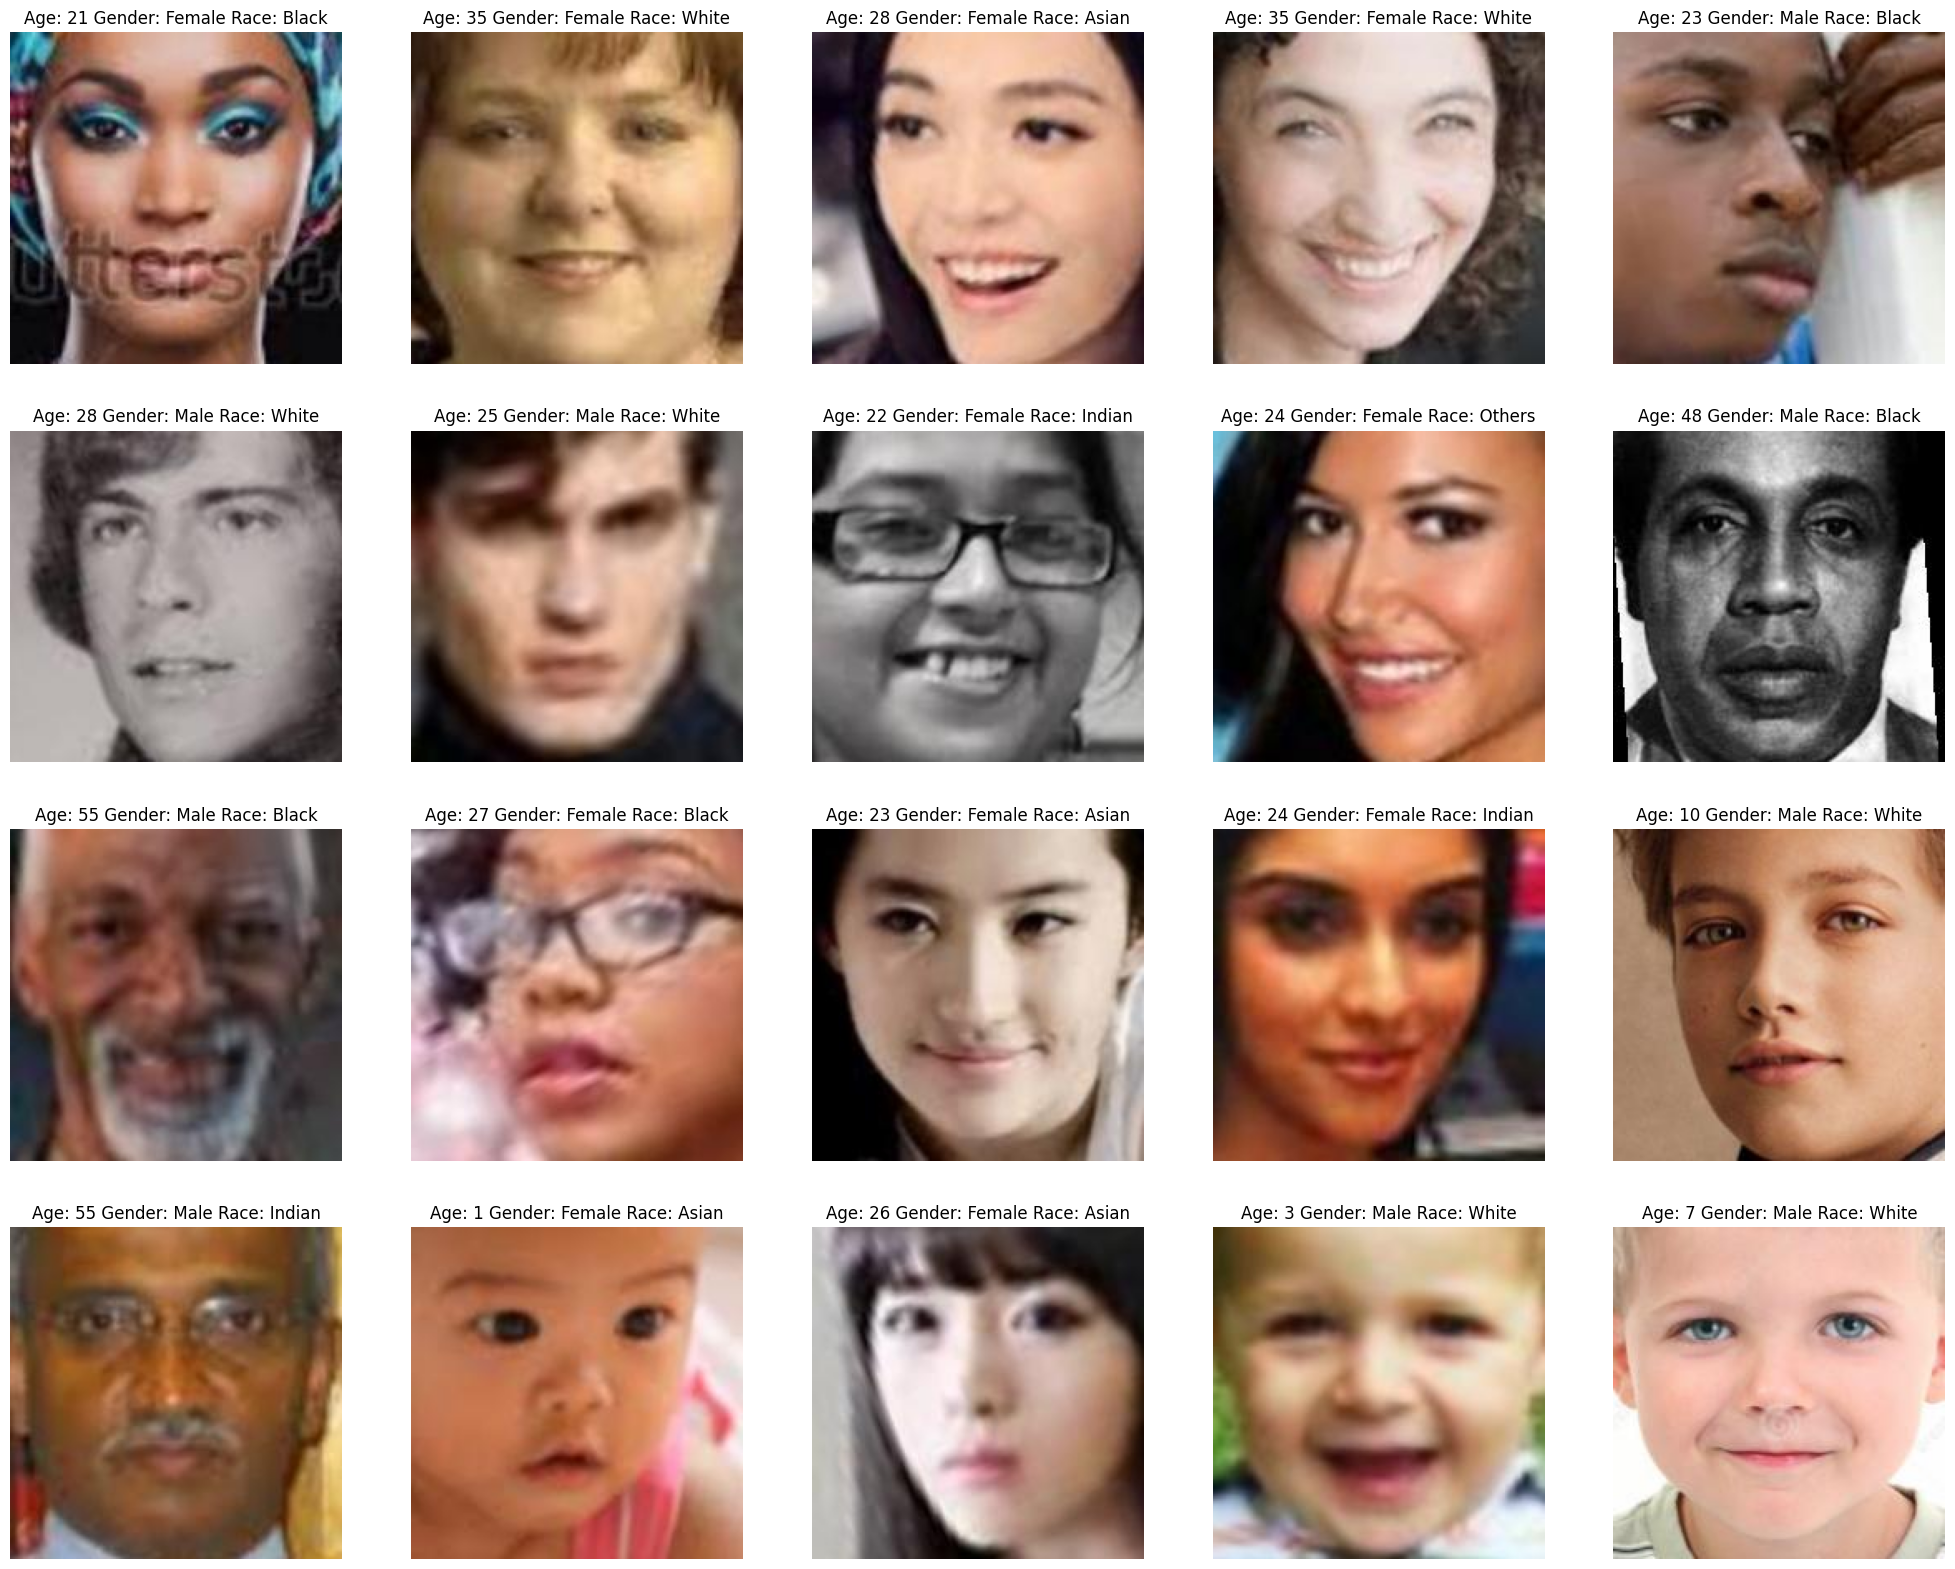

In [23]:
# Plotting Images
files = df.iloc[0:20]
plt.figure(figsize=(25,25))

for index, file, age, gender, race in files.itertuples():
  plt.subplot(5,5, index+1)
  img = load_img("/content/content/UTKFace/"+file)
  img = np.array(img)
  plt.imshow(img)
  plt.title(f"Age: {age} Gender: {gender_dict[gender]} Race: {race_dict[race]}")
  plt.axis("off")

In [24]:
df.count()

,0
image,23705
age,23705
gender,23705
race,23705


In [25]:
train, test = train_test_split(df, train_size=0.8, random_state=42)

In [26]:
train.shape

(18964, 4)

In [27]:
test.shape

(4741, 4)

In [28]:
train.head()

,image,age,gender,race
21099,47_0_4_20170104002132109.jpg.chip.jpg,47,0,4
20882,25_0_2_20170117140102359.jpg.chip.jpg,25,0,2
21549,65_0_2_20170120223049075.jpg.chip.jpg,65,0,2
13630,23_0_2_20170116172805150.jpg.chip.jpg,23,0,2
8227,50_0_1_20170120220929108.jpg.chip.jpg,50,0,1


In [29]:
#converting Image to numpy array (extracting feature)

x_train = []
for file in train.image:
  img = load_img("/content/content/UTKFace/"+file).convert("RGB")
  img = img.resize((224, 224))
  img = np.array(img)
  x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 224, 224, 3)

In [30]:
x_train.shape

(18964, 224, 224, 3)

In [31]:
# Normalizing Data
# x_train = x_train/255

In [32]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)
y_race = np.array(train.race)

In [33]:
from tensorflow.keras.utils import to_categorical

# Convert race to One Hot Encoding
y_race = to_categorical(y_race, num_classes=5)

# Creating Model

Using Convolutional Neural Network but with skip connections. Skip connections are used in Residual NN but implemented CNN with little Skip connections (shortcut).

In [34]:
from tensorflow.keras.applications import VGG16

# Load VGG16 model
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze VGG16 layers
for layer in conv_base.layers:
  layer.trainable = False

# Input Layers
input_size = (224, 224, 3)
inputs = Input(input_size)

# Apply VGG16 base model
X = conv_base(inputs)

# Flatten output
X = Flatten()(X)

# Dense layers for shared representation
dense_1 = Dense(256, activation="relu")(X)
dropout_1 = Dropout(0.4)(dense_1)

# Dense layers specific to each others
dense_2 = Dense(256, activation="relu")(X)
dropout_2 = Dropout(0.4)(dense_2)

dense_3 = Dense(128, activation="relu")(X)
dropout_3 = Dropout(0.4)(dense_3)

# Output Layers

output_1 = Dense(1, activation="sigmoid", name="gender_output")(dropout_1) # Gender Output
output_2 = Dense(1, activation="linear", name="age_output")(dropout_2) # Age Output
output_3 = Dense(5, activation="softmax", name="race_output")(dropout_3) # Race Output


model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      6,422,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │      6,422,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │      3,211,392 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output (Dense)     │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_output (Dense)        │ (None, 1)              │            257 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ race_output (Dense)       │ (None, 5)              │            645 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 30,772,807 (117.39 MB)

 Trainable params: 16,058,119 (61.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [35]:
# Compile Model
model.compile(optimizer="adam",
              loss={
                  "gender_output" : "binary_crossentropy",
                  "age_output" : "mean_squared_error",
                  "race_output" : "categorical_crossentropy"},
              metrics={
                  "gender_output" : "accuracy",
                  "age_output" : "mean_absolute_error",
                  "race_output" : "accuracy"
              }
              )

# Training Model

In [36]:
y_race

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save the model with the best 'race_output' performance
checkpoint = ModelCheckpoint(
    "best_model_by_race_output.keras", # Path where the best model will be saved
    monitor="val_race_output_loss", # Metric to monitor
    save_best_only=True, # Save only the best model
    mode="min", # Mode for the metric: 'min' for loss
    verbose=1 # Verbosity level
)


# Train Model

history = model.fit(x_train,{"gender_output": y_gender, "age_output": y_age, "race_output": y_race},
                    epochs=20, batch_size=32, validation_split=0.1, callbacks=[checkpoint]
)

Epoch 1/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 121s 184ms/step - age_output_mean_absolute_error: 30.0437 - gender_output_accuracy: 0.8059 - loss: 2758.5469 - race_output_accuracy: 0.4071 - val_age_output_mean_absolute_error: 14.3419 - val_gender_output_accuracy: 0.8914 - val_loss: 336.8487 - val_race_output_accuracy: 0.4133
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_race_output_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


534/534 ━━━━━━━━━━━━━━━━━━━━ 81s 151ms/step - age_output_mean_absolute_error: 18.0835 - gender_output_accuracy: 0.8807 - loss: 675.5801 - race_output_accuracy: 0.4345 - val_age_output_mean_absolute_error: 13.7036 - val_gender_output_accuracy: 0.8930 - val_loss: 308.3290 - val_race_output_accuracy: 0.4133
Epoch 3/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 78s 147ms/step - age_output_mean_absolute_error: 17.0968 - gender_output_accuracy: 0.9054 - loss: 629.0134 - race_output_accuracy: 0.4317 - val_age_output_mean_absolute_error: 13.5400 - val_gender_output_accuracy: 0.8951 - val_loss: 311.8685 - val_race_output_accuracy: 0.4149
Epoch 4/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 152ms/step - age_output_mean_absolute_error: 17.2278 - gender_output_accuracy: 0.9158 - loss: 646.2192 - race_output_accuracy: 0.4313 - val_age_output_mean_absolute_error: 13.0210 - val_gender_output_accuracy: 0.9004 - val_loss: 285.5198 - val_race_output_accuracy: 0.4133
Epoch 5/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 79s 147ms/step - age

# Visualizing Loss

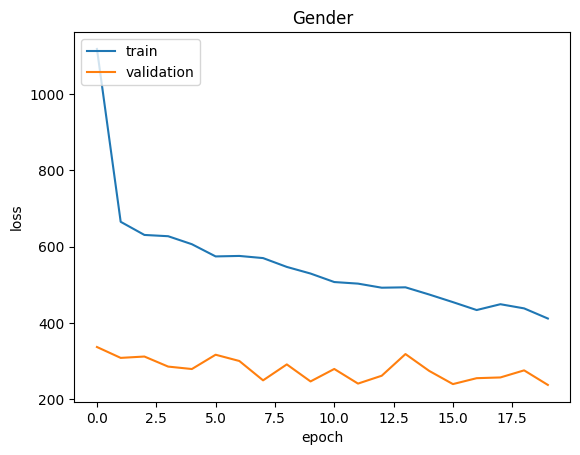

In [41]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Gender")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

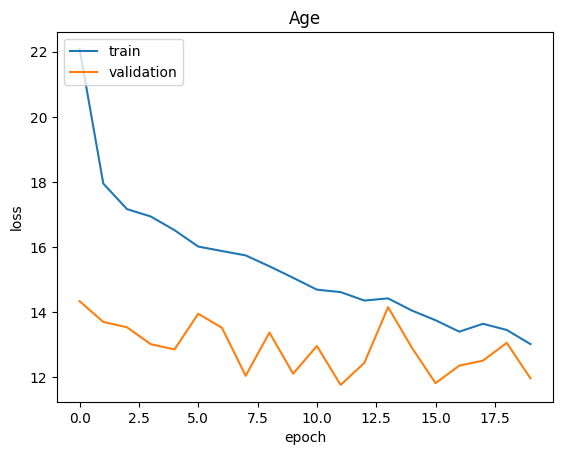

In [44]:
plt.plot(history.history["age_output_mean_absolute_error"])
plt.plot(history.history["val_age_output_mean_absolute_error"])
plt.title("Age")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

# Accuracy

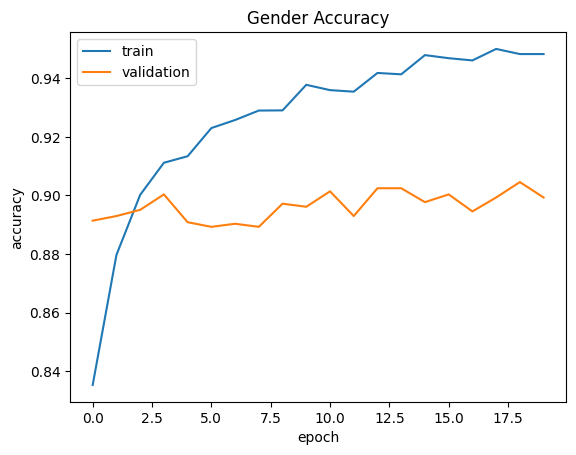

In [46]:
plt.plot(history.history["gender_output_accuracy"])
plt.plot(history.history["val_gender_output_accuracy"])
plt.title("Gender Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

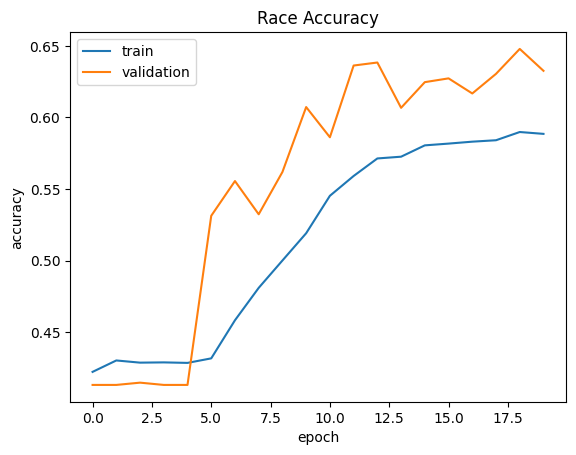

In [47]:
plt.plot(history.history["race_output_accuracy"])
plt.plot(history.history["val_race_output_accuracy"])
plt.title("Race Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

# Predicting Test Image

In [48]:
np.argmax(y_race[index])

0

Original: Gender =  Male Age =  16 Race =  White
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted: Gender =  Male Age =  11 Race =  White


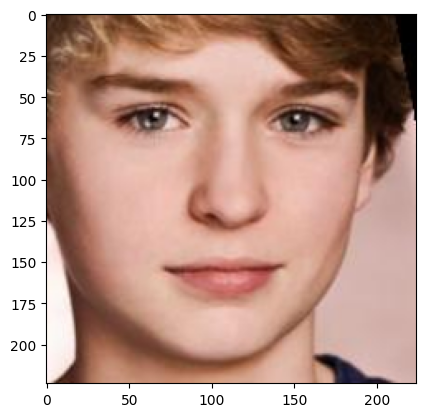

In [81]:
index = 204
print("Original: Gender = ", gender_dict[y_gender[index]], "Age = ", y_age[index], "Race = ", race_dict[np.argmax(y_race[index])])

pred = model.predict(x_train[index]. reshape(1, 224, 224, 3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
pred_race = race_dict[round(np.argmax(pred[2][0]))]

print("Predicted: Gender = ", pred_gender, "Age = ", pred_age, "Race = ", pred_race)
plt.imshow(x_train[index].reshape(224, 224, 3))